## Libraries and Data Download

In [ ]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torch
import numpy as np

In [ ]:
# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

100%|██████████| 142k/142k [00:00<00:00, 69.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/janiobachmann/bank-marketing-dataset/versions/1


In [ ]:
#Loading the dataset to a pandas dataframe
file_path = os.path.join(path, "bank.csv")
df = pd.read_csv(file_path, sep=",")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


##Intial Data Exploration

In [ ]:
#Size of our dataframe
print(f"The df dimensions are: {df.shape}")

df.describe()

The df dimensions are: (11162, 17)


,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [ ]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [ ]:
#Showing all the values for object columns and a sample of 5 unique values for int64 columns
for col in df.columns:
    if df[col].dtype == "object":
        print(f"{col}: {df[col].unique()}")
    else:
        print(f"{col}: {df[col].unique()[:5]}")

age: [59 56 41 55 54]
job: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital: ['married' 'single' 'divorced']
education: ['secondary' 'tertiary' 'primary' 'unknown']
default: ['no' 'yes']
balance: [2343   45 1270 2476  184]
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
day: [5 6 7 8 9]
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
duration: [1042 1467 1389  579  673]
campaign: [1 2 3 4 6]
pdays: [ -1 166  91 147 170]
previous: [0 1 4 2 3]
poutcome: ['unknown' 'other' 'failure' 'success']
deposit: ['yes' 'no']


##Data Preparation

In [ ]:
#Converting default, housing,loan, and deposit into binary columns (0 or 1)
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['deposit'] = df['deposit'].map({'no': 0, 'yes': 1})

In [ ]:
#Splitting our train and test dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

test_df_copy = test_df.copy()

In [ ]:
train_labels = train_df['deposit']
test_labels = test_df['deposit']


train_df = train_df.drop(columns=['deposit'])
test_df = test_df.drop(columns=['deposit'])

###One-Hot Encoding

From our df.info we can see that there are multiple non numeric features

In [ ]:
#Combining both dataframes
features=pd.concat(objs=[train_df,test_df],axis=0)

numeric_features = features.dtypes[features.dtypes != 'object'].index
non_numeric_features = features.dtypes[features.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
        'campaign', 'pdays', 'previous'],
       dtype='object'),
 Index(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], dtype='object'))

In [ ]:
features = pd.get_dummies(features, columns=non_numeric_features)

In [ ]:
# Standardize numeric features
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [ ]:
# recheck the mean and std after standardization
features[numeric_features].mean(), features[numeric_features].std()

(age         2.743629e-16
 default    -1.177660e-17
 balance     1.623261e-17
 housing    -1.145831e-17
 loan       -4.456011e-18
 day        -1.846062e-17
 duration    4.456011e-17
 campaign    5.729157e-18
 pdays      -1.145831e-17
 previous   -8.912021e-18
 dtype: float64,
 age         1.0
 default     1.0
 balance     1.0
 housing     1.0
 loan        1.0
 day         1.0
 duration    1.0
 campaign    1.0
 pdays       1.0
 previous    1.0
 dtype: float64)

In [ ]:
#Number of features
features.shape

(11162, 48)

In [ ]:
features.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3955,-1.110681,-0.123611,1.306022,-0.947574,-0.387906,-0.671917,1.930139,0.915323,1.366973,0.945653,...,False,False,False,False,False,True,True,False,False,False
11150,-0.607045,-0.123611,-0.363841,-0.947574,-0.387906,0.634382,-0.167067,0.180590,-0.481162,-0.363244,...,False,False,False,False,False,False,False,False,False,True
5173,0.568106,-0.123611,-0.411587,-0.947574,-0.387906,-0.671917,0.639551,-0.554144,0.364750,0.073055,...,False,False,False,True,False,False,False,False,True,False
3017,0.987802,-0.123611,0.134079,-0.947574,-0.387906,-0.078145,-0.060479,-0.554144,-0.481162,-0.363244,...,False,False,False,False,False,False,False,False,False,True
2910,0.987802,-0.123611,0.029597,-0.947574,-0.387906,-0.553162,-0.593423,0.180590,0.419918,2.690848,...,False,False,False,True,False,False,False,False,True,False


Now we have 48 features instead of 17

###Feature Extraction

In [ ]:
# we extract out the train and test features
train_features = features.iloc[:len(train_labels)]
test_features = features.iloc[len(train_labels):]
train_features.shape, test_features.shape

((8929, 48), (2233, 48))

In [ ]:
# Convert training features and labels to PyTorch tensors
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)
test_labels = torch.tensor(test_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

In [ ]:
train_labels.shape

torch.Size([8929, 1])

##Training and validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.

In [ ]:
train_indices, valid_indices, train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_df.index, train_features, train_labels, test_size=0.1, random_state=50)

In [ ]:
print(train_features.shape)
print(valid_features.shape)

torch.Size([8036, 48])
torch.Size([893, 48])


Creating the DataLoader

In [ ]:
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_data = TensorDataset(valid_features, valid_labels)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)

In [ ]:
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch import nn, optim

def train_validation(model, criterion,train_loader, valid_loader, optimizer, epochs):

    steps = 0
    train_losses, valid_losses = [], []
    intial_validation_loss = 10000

    for e in range(epochs):
        tot_train_loss = 0


        model.train()
        for features, labels in train_loader:

            features=features.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            log_ps = model(features)
            loss = criterion(log_ps, labels)

            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()
        else:
            accuracy = 0
            tot_valid_loss = 0
            correct_predictions = 0

            with torch.no_grad():
                model.eval()
                for features, labels in valid_loader:
                    # move features and labels to GPU
                    features = features.to(device)
                    labels = labels.to(device)

                    log_ps = model(features)
                    # calculate the loss
                    loss = criterion(log_ps, labels)
                    # update running validation loss
                    tot_valid_loss += loss.item()


                    #Count how many I classify correctly consdiering a treshold of 0.5
                    ps=torch.sigmoid(log_ps)
                    predictions = (ps > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
                    correct_predictions+= (predictions == labels).float().sum()

            model.train()
            accuracy = correct_predictions / len(valid_loader.dataset)
            train_loss =tot_train_loss/len(train_loader)
            valid_loss = tot_valid_loss/len(valid_loader)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

        print("Epoch: {}/{}.. ".format(e, epochs),
                    "Training Loss: {:.3f}.. ".format(train_loss),
                    "Validation Loss: {:.3f}.. ".format(valid_loss),
                    "Validation Accuracy: {:.3f}".format(accuracy))

        #Save the best model with validation_loss
        if valid_loss <= intial_validation_loss:
            intial_validation_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, valid_losses

##Modelling

Epoch: 0/50..  Training Loss: 0.616..  Validation Loss: 0.614..  Validation Accuracy: 0.803
Epoch: 1/50..  Training Loss: 0.602..  Validation Loss: 0.613..  Validation Accuracy: 0.787
Epoch: 2/50..  Training Loss: 0.598..  Validation Loss: 0.616..  Validation Accuracy: 0.828
Epoch: 3/50..  Training Loss: 0.593..  Validation Loss: 0.608..  Validation Accuracy: 0.812
Epoch: 4/50..  Training Loss: 0.592..  Validation Loss: 0.614..  Validation Accuracy: 0.819
Epoch: 5/50..  Training Loss: 0.593..  Validation Loss: 0.614..  Validation Accuracy: 0.824
Epoch: 6/50..  Training Loss: 0.589..  Validation Loss: 0.608..  Validation Accuracy: 0.823
Epoch: 7/50..  Training Loss: 0.588..  Validation Loss: 0.609..  Validation Accuracy: 0.840
Epoch: 8/50..  Training Loss: 0.586..  Validation Loss: 0.608..  Validation Accuracy: 0.833
Epoch: 9/50..  Training Loss: 0.586..  Validation Loss: 0.609..  Validation Accuracy: 0.835
Epoch: 10/50..  Training Loss: 0.586..  Validation Loss: 0.616..  Validation Acc

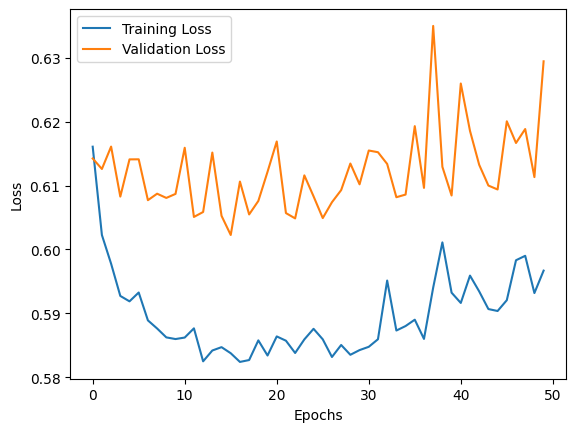

In [ ]:
#Model when we first started the project

base_model = nn.Sequential(nn.Linear(train_features.shape[1], 512),
                      nn.ReLU(),
                      nn.Linear(512, 64),
                      nn.ReLU(),
                      nn.Linear(64,1),
                      nn.Sigmoid())
base_model = base_model.to(device)

#Criterion for binary cases
criterion = nn.BCEWithLogitsLoss()
epochs = 50
learning_rate=0.01
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

train_losses, valid_losses = train_validation(base_model, criterion, train_loader, valid_loader, optimizer, epochs)

#Plotting the training and validation Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch: 0/50..  Training Loss: 0.680..  Validation Loss: 0.665..  Validation Accuracy: 0.692
Epoch: 1/50..  Training Loss: 0.647..  Validation Loss: 0.635..  Validation Accuracy: 0.725
Epoch: 2/50..  Training Loss: 0.610..  Validation Loss: 0.602..  Validation Accuracy: 0.737
Epoch: 3/50..  Training Loss: 0.569..  Validation Loss: 0.566..  Validation Accuracy: 0.751
Epoch: 4/50..  Training Loss: 0.530..  Validation Loss: 0.535..  Validation Accuracy: 0.760
Epoch: 5/50..  Training Loss: 0.497..  Validation Loss: 0.509..  Validation Accuracy: 0.774
Epoch: 6/50..  Training Loss: 0.471..  Validation Loss: 0.489..  Validation Accuracy: 0.785
Epoch: 7/50..  Training Loss: 0.450..  Validation Loss: 0.474..  Validation Accuracy: 0.802
Epoch: 8/50..  Training Loss: 0.435..  Validation Loss: 0.462..  Validation Accuracy: 0.816
Epoch: 9/50..  Training Loss: 0.423..  Validation Loss: 0.455..  Validation Accuracy: 0.815
Epoch: 10/50..  Training Loss: 0.414..  Validation Loss: 0.449..  Validation Acc

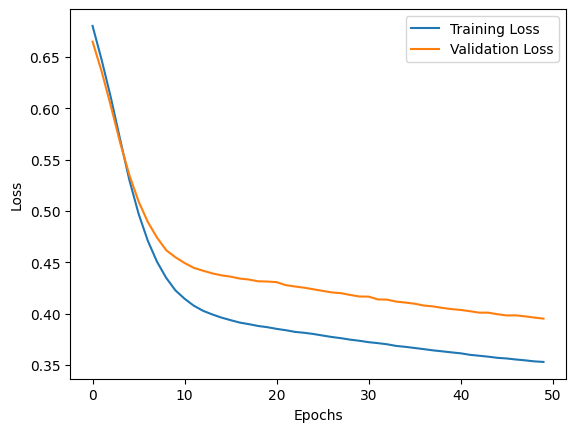

The lowest validation loss is: 0.3950840107032231


In [ ]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x= self.fc2(x)
        return x

first_model = Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()
epochs = 50
learning_rate=3e-4
optimizer = optim.Adam(first_model.parameters(), lr=learning_rate)
train_losses, valid_losses = train_validation(first_model, criterion, train_loader, valid_loader, optimizer, epochs)

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Show the lowest validation Loss
print(f"The lowest validation loss is: {min(valid_losses)}")

Epoch: 0/50..  Training Loss: 0.656..  Validation Loss: 0.630..  Validation Accuracy: 0.703
Epoch: 1/50..  Training Loss: 0.588..  Validation Loss: 0.572..  Validation Accuracy: 0.757
Epoch: 2/50..  Training Loss: 0.524..  Validation Loss: 0.522..  Validation Accuracy: 0.778
Epoch: 3/50..  Training Loss: 0.475..  Validation Loss: 0.485..  Validation Accuracy: 0.788
Epoch: 4/50..  Training Loss: 0.441..  Validation Loss: 0.463..  Validation Accuracy: 0.806
Epoch: 5/50..  Training Loss: 0.419..  Validation Loss: 0.451..  Validation Accuracy: 0.819
Epoch: 6/50..  Training Loss: 0.406..  Validation Loss: 0.443..  Validation Accuracy: 0.817
Epoch: 7/50..  Training Loss: 0.397..  Validation Loss: 0.438..  Validation Accuracy: 0.822
Epoch: 8/50..  Training Loss: 0.391..  Validation Loss: 0.432..  Validation Accuracy: 0.821
Epoch: 9/50..  Training Loss: 0.388..  Validation Loss: 0.431..  Validation Accuracy: 0.822
Epoch: 10/50..  Training Loss: 0.384..  Validation Loss: 0.428..  Validation Acc

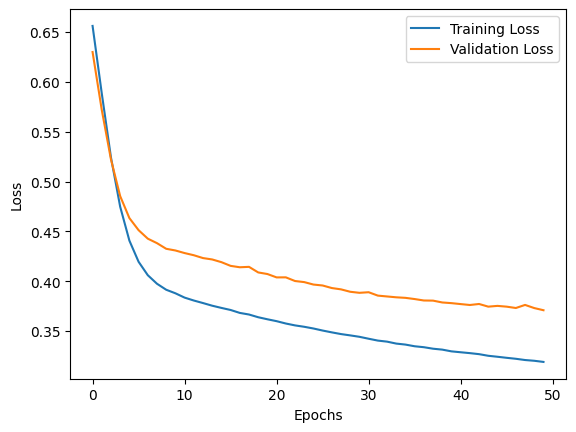

The lowest validation loss is: 0.3708558465753283


In [ ]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x= self.fc2(x)
        return x

second_model = Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()
epochs = 50
learning_rate=3e-4
optimizer = optim.Adam(second_model.parameters(), lr=learning_rate)
train_losses, valid_losses = train_validation(second_model, criterion, train_loader, valid_loader, optimizer, epochs)

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Show the lowest validation Loss
print(f"The lowest validation loss is: {min(valid_losses)}")

Epoch: 0/50..  Training Loss: 0.619..  Validation Loss: 0.569..  Validation Accuracy: 0.751
Epoch: 1/50..  Training Loss: 0.507..  Validation Loss: 0.497..  Validation Accuracy: 0.792
Epoch: 2/50..  Training Loss: 0.444..  Validation Loss: 0.457..  Validation Accuracy: 0.804
Epoch: 3/50..  Training Loss: 0.412..  Validation Loss: 0.440..  Validation Accuracy: 0.814
Epoch: 4/50..  Training Loss: 0.395..  Validation Loss: 0.433..  Validation Accuracy: 0.821
Epoch: 5/50..  Training Loss: 0.386..  Validation Loss: 0.430..  Validation Accuracy: 0.825
Epoch: 6/50..  Training Loss: 0.381..  Validation Loss: 0.424..  Validation Accuracy: 0.822
Epoch: 7/50..  Training Loss: 0.375..  Validation Loss: 0.422..  Validation Accuracy: 0.833
Epoch: 8/50..  Training Loss: 0.370..  Validation Loss: 0.418..  Validation Accuracy: 0.835
Epoch: 9/50..  Training Loss: 0.367..  Validation Loss: 0.415..  Validation Accuracy: 0.833
Epoch: 10/50..  Training Loss: 0.363..  Validation Loss: 0.410..  Validation Acc

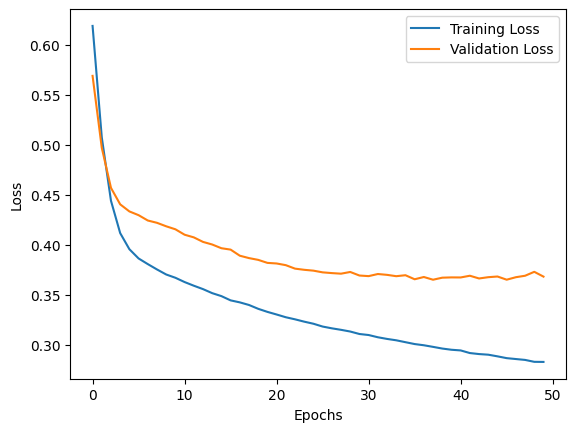

The lowest validation loss is: 0.3649449944496155


In [ ]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x= self.fc2(x)
        return x

third_model = Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()
epochs = 50
learning_rate=3e-4
optimizer = optim.Adam(third_model.parameters(), lr=learning_rate)
train_losses, valid_losses = train_validation(third_model, criterion, train_loader, valid_loader, optimizer, epochs)

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Show the lowest validation Loss
print(f"The lowest validation loss is: {min(valid_losses)}")

Epoch: 0/50..  Training Loss: 0.648..  Validation Loss: 0.600..  Validation Accuracy: 0.786
Epoch: 1/50..  Training Loss: 0.517..  Validation Loss: 0.485..  Validation Accuracy: 0.813
Epoch: 2/50..  Training Loss: 0.418..  Validation Loss: 0.433..  Validation Accuracy: 0.821
Epoch: 3/50..  Training Loss: 0.384..  Validation Loss: 0.416..  Validation Accuracy: 0.820
Epoch: 4/50..  Training Loss: 0.370..  Validation Loss: 0.405..  Validation Accuracy: 0.842
Epoch: 5/50..  Training Loss: 0.361..  Validation Loss: 0.396..  Validation Accuracy: 0.840
Epoch: 6/50..  Training Loss: 0.354..  Validation Loss: 0.390..  Validation Accuracy: 0.844
Epoch: 7/50..  Training Loss: 0.350..  Validation Loss: 0.387..  Validation Accuracy: 0.838
Epoch: 8/50..  Training Loss: 0.344..  Validation Loss: 0.380..  Validation Accuracy: 0.837
Epoch: 9/50..  Training Loss: 0.340..  Validation Loss: 0.377..  Validation Accuracy: 0.847
Epoch: 10/50..  Training Loss: 0.336..  Validation Loss: 0.377..  Validation Acc

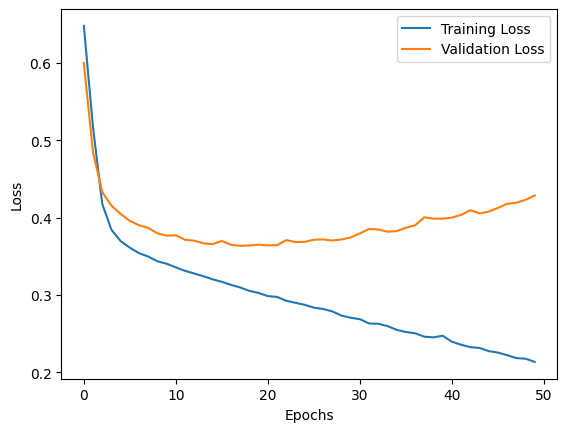

The lowest validation loss is: 0.36363703863961355


In [ ]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.fc2 = nn.Linear(512, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        x= self.fc4(x)
        return x


fourth_model = Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()
epochs = 50
learning_rate=3e-4
optimizer = optim.Adam(fourth_model.parameters(), lr=learning_rate)
train_losses, valid_losses = train_validation(fourth_model, criterion, train_loader, valid_loader, optimizer, epochs)

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Show the lowest validation Loss
print(f"The lowest validation loss is: {min(valid_losses)}")

Epoch: 0/50..  Training Loss: 0.662..  Validation Loss: 0.610..  Validation Accuracy: 0.728
Epoch: 1/50..  Training Loss: 0.512..  Validation Loss: 0.453..  Validation Accuracy: 0.805
Epoch: 2/50..  Training Loss: 0.399..  Validation Loss: 0.414..  Validation Accuracy: 0.829
Epoch: 3/50..  Training Loss: 0.374..  Validation Loss: 0.402..  Validation Accuracy: 0.839
Epoch: 4/50..  Training Loss: 0.364..  Validation Loss: 0.395..  Validation Accuracy: 0.840
Epoch: 5/50..  Training Loss: 0.358..  Validation Loss: 0.390..  Validation Accuracy: 0.841
Epoch: 6/50..  Training Loss: 0.352..  Validation Loss: 0.387..  Validation Accuracy: 0.842
Epoch: 7/50..  Training Loss: 0.347..  Validation Loss: 0.382..  Validation Accuracy: 0.842
Epoch: 8/50..  Training Loss: 0.343..  Validation Loss: 0.380..  Validation Accuracy: 0.845
Epoch: 9/50..  Training Loss: 0.340..  Validation Loss: 0.377..  Validation Accuracy: 0.842
Epoch: 10/50..  Training Loss: 0.335..  Validation Loss: 0.377..  Validation Acc

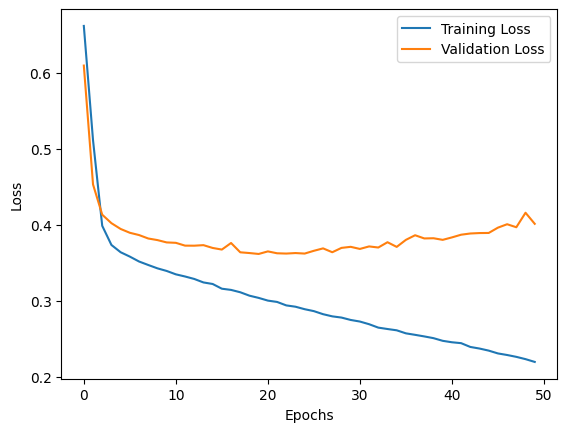

The lowest validation loss is: 0.36194739597184317


In [ ]:
#Updated model with weight decay
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.fc2 = nn.Linear(512, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        x= self.fc4(x)
        return x


fifth_model = Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()
epochs = 50
learning_rate=3e-4
optimizer = optim.Adam(fifth_model.parameters(), lr=learning_rate, weight_decay=3e-5)
train_losses, valid_losses = train_validation(fifth_model, criterion, train_loader, valid_loader, optimizer, epochs)

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Show the lowest validation Loss
print(f"The lowest validation loss is: {min(valid_losses)}")

Epoch: 0/100..  Training Loss: 0.686..  Validation Loss: 0.657..  Validation Accuracy: 0.760
Epoch: 1/100..  Training Loss: 0.613..  Validation Loss: 0.551..  Validation Accuracy: 0.755
Epoch: 2/100..  Training Loss: 0.529..  Validation Loss: 0.472..  Validation Accuracy: 0.807
Epoch: 3/100..  Training Loss: 0.455..  Validation Loss: 0.420..  Validation Accuracy: 0.819
Epoch: 4/100..  Training Loss: 0.424..  Validation Loss: 0.409..  Validation Accuracy: 0.819
Epoch: 5/100..  Training Loss: 0.414..  Validation Loss: 0.406..  Validation Accuracy: 0.824
Epoch: 6/100..  Training Loss: 0.406..  Validation Loss: 0.400..  Validation Accuracy: 0.834
Epoch: 7/100..  Training Loss: 0.399..  Validation Loss: 0.399..  Validation Accuracy: 0.830
Epoch: 8/100..  Training Loss: 0.396..  Validation Loss: 0.399..  Validation Accuracy: 0.830
Epoch: 9/100..  Training Loss: 0.392..  Validation Loss: 0.396..  Validation Accuracy: 0.834
Epoch: 10/100..  Training Loss: 0.391..  Validation Loss: 0.392..  Val

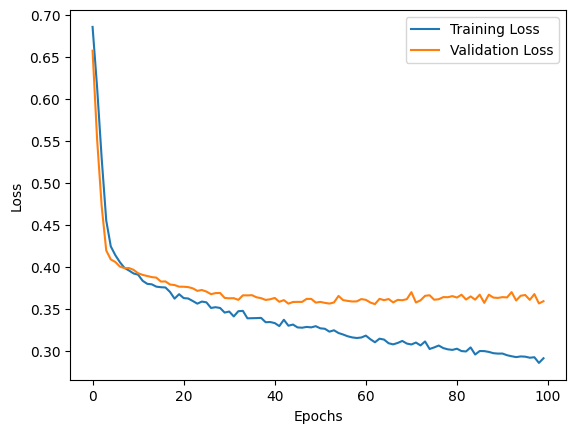

The lowest validation loss is: 0.35573747754096985


In [ ]:
#Updated model with dropout and weight decay
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.fc2 = nn.Linear(512, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3049)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x= self.dropout(F.relu(self.fc2(x)))
        x= self.dropout(F.relu(self.fc3(x)))
        x= self.fc4(x)
        return x

complexed_updated_model = Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()
epochs = 100
learning_rate=3e-4
optimizer = optim.Adam(complexed_updated_model.parameters(), lr=learning_rate, weight_decay=3e-3)
train_losses, valid_losses = train_validation(complexed_updated_model, criterion, train_loader, valid_loader, optimizer, epochs)

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Show the lowest validation Loss
print(f"The lowest validation loss is: {min(valid_losses)}")

In [ ]:
#Import best model
complexed_updated_model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
#Function to define a test of a model
def test(model, test_loader):
    model.eval()
    pred_labels = torch.tensor([], device=device)
    with torch.no_grad():
        for features in test_loader:
            features = features[0].to(device)
            output = (torch.sigmoid(model.forward(features)))
            pred_labels = torch.cat((pred_labels, output), dim=0)
    return pred_labels

In [ ]:
#Create an ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pred_labels = test(complexed_updated_model, test_loader)
fpr, tpr, thresholds = roc_curve(test_labels.cpu(), pred_labels.cpu())
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.9149834180249203


In [ ]:
pred_labels_base= test(base_model, test_loader)
fpr_base, tpr_base, thresholds = roc_curve(test_labels.cpu(), pred_labels_base.cpu())
roc_auc_base = auc(fpr_base, tpr_base)
print(f"AUC: {roc_auc_base}")

AUC: 0.7934402735423053


(0.0, 1.05)

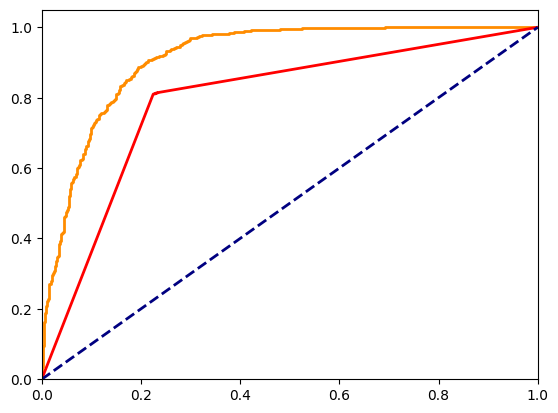

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_base, tpr_base, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_base)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

In [ ]:
#Putting our predicitons vs test_labels
test_predictions = np.where(pred_labels.cpu().numpy()>0.5, 1,0)

#Putting it together on a dataframe
Comparison_df = pd.DataFrame({'Test Labels': test_labels.flatten(), 'Test Predictions': test_predictions.flatten()})

Text(0.5, 1.0, 'Confusion Matrix')

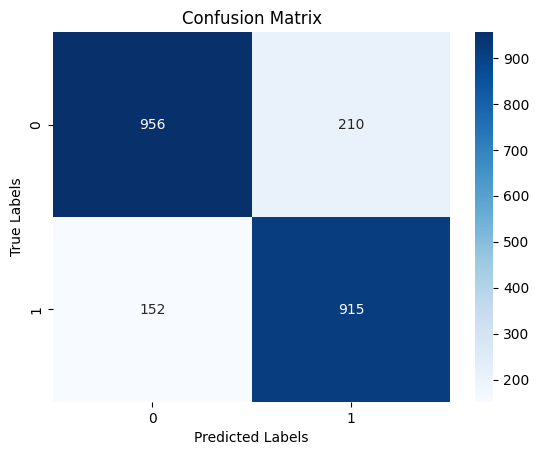

In [ ]:
 #Confusion matrix based on Comparison_df
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Comparison_df['Test Labels'], Comparison_df['Test Predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')